## Imports and Libaries

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random

## Data preperation and pre-processing

In [2]:
!unzip Face\ Image\ Dataset_2020.zip -d ./face_dataset

Archive:  Face Image Dataset_2020.zip
  inflating: ./face_dataset/README   
  inflating: ./face_dataset/s1/1.pgm  
  inflating: ./face_dataset/s1/10.pgm  
  inflating: ./face_dataset/s1/2.pgm  
  inflating: ./face_dataset/s1/3.pgm  
  inflating: ./face_dataset/s1/4.pgm  
  inflating: ./face_dataset/s1/5.pgm  
  inflating: ./face_dataset/s1/6.pgm  
  inflating: ./face_dataset/s1/7.pgm  
  inflating: ./face_dataset/s1/8.pgm  
  inflating: ./face_dataset/s1/9.pgm  
  inflating: ./face_dataset/s10/1.pgm  
  inflating: ./face_dataset/s10/10.pgm  
  inflating: ./face_dataset/s10/2.pgm  
  inflating: ./face_dataset/s10/3.pgm  
  inflating: ./face_dataset/s10/4.pgm  
  inflating: ./face_dataset/s10/5.pgm  
  inflating: ./face_dataset/s10/6.pgm  
  inflating: ./face_dataset/s10/7.pgm  
  inflating: ./face_dataset/s10/8.pgm  
  inflating: ./face_dataset/s10/9.pgm  
  inflating: ./face_dataset/s11/1.pgm  
  inflating: ./face_dataset/s11/10.pgm  
  inflating: ./face_dataset/s11/2.pgm  
  inflating

In [5]:
folder_path = 'face_dataset/'

train_data = []
test_date = []
X_train = []
Y_train = []
X_test = []
Y_test = []
train_ratio = 0.6
unprocessed_img_dim = None

for folder in os.listdir(folder_path):
    if os.path.isfile(folder_path + folder):
      continue
    D = []
    for file in os.listdir( folder_path + folder + '/'):
        img = cv2.imread( folder_path + folder + '/' + file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if unprocessed_img_dim is None:
          unprocessed_img_dim = img.shape
        img = img.flatten()
        D.append(img)
    random.shuffle(D)
    train_boundary = train_ratio * len(D)
    label = folder
    for i in range(len(D)):
        if i < train_boundary:
            X_train.append(D[i])
            Y_train.append(label)
        else:
            X_test.append(D[i])
            Y_test.append(label)
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

## a) PCA Implementation and analysis

In [11]:
class PCA(object):
  match_threshold = 40000000

  def __init__(self, X_train, Y_train, k = 100):
    self.k = k
    self.X_train = X_train
    self.Y_train = Y_train

    self.mean_image = None
    self.weights = None
    self.eigen_faces = None
    self.W = None

    self.fit(X_train)
  
  def fit(self, X_train):
    
    self.mean_image = np.mean(X_train, axis = 0)
    P = len(X_train)
    self.W = (X_train - self.mean_image)
    
    C = np.matmul(self.W , self.W.T) / (P - 1)
    eigen_vectors, _, _ = np.linalg.svd(C)
    final_eigen_vectors = eigen_vectors[:,:self.k]
    
    self.eigen_faces = np.matmul(final_eigen_vectors.T, self.W )
    self.weights = np.matmul( self.W , self.eigen_faces.T)
    
  def predict(self, X):
    X_centred = (X - self.mean_image)
    weight_img = np.matmul( X_centred, self.eigen_faces.T)
    min_dist = 1e19
    ind = 0
    for i in range( len(self.weights) ):
        dist = np.linalg.norm(weight_img - self.weights[i])
        if  dist < min_dist:
            min_dist, ind = dist, i
    if min_dist >= PCA.match_threshold:
      return "Not Enrolled"
    return self.Y_train[ind]
    
  def getAccuracy(self, X_test, Y_test): 
    freq = 0
    n = len(X_test)
    for i in range(n):
      if self.predict(X_test[i]) == Y_test[i]:
        freq += 1
    return freq * 100 / n
        
  def displayMeanImage(self):
    plt.imshow(self.mean_image.reshape(unprocessed_img_dim), cmap = 'gray')
    plt.title('Mean Image')

In [12]:
k = 100
PCA_model = PCA(X_train, Y_train, k)
accuracy = PCA_model.getAccuracy(X_test, Y_test)
print(f'Accuracy : {round(accuracy, 2)}%')

Accuracy : 88.75%


### Visualizations and Plots

#### k vs Accuracy plot

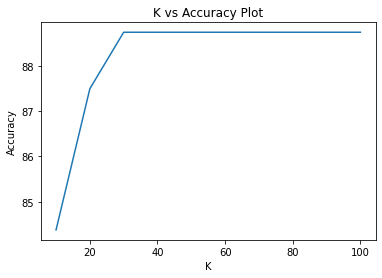

In [13]:
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
acc_list = []
for k in k_list:
  PCA_model = PCA(X_train, Y_train, k)
  accuracy = PCA_model.getAccuracy(X_test, Y_test)
  acc_list.append(accuracy)

plt.plot(k_list, acc_list)
plt.title('K vs Accuracy Plot')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

#### Input data before centering

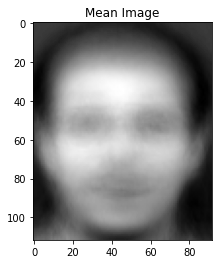

In [14]:
PCA_model.displayMeanImage()

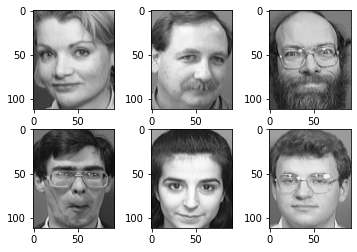

In [15]:
fig, ax = plt.subplots(nrows = 2, ncols = 3)
sub_data_ind_list = random.sample(range(0, len(X_train)), 6) 
ind = 0
for i, a in enumerate(ax.ravel()):
  img = X_train[sub_data_ind_list[ind]]
  a.imshow(img.reshape(unprocessed_img_dim), cmap='gray')
  ind += 1

#### Input data after centering

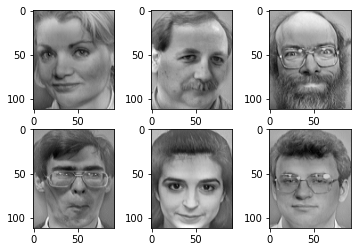

In [16]:
fig, ax = plt.subplots(nrows = 2, ncols = 3)
ind = 0
for i, a in enumerate(ax.ravel()):
  img = PCA_model.W[sub_data_ind_list[ind]]
  a.imshow(img.reshape(unprocessed_img_dim), cmap='gray')
  ind += 1

#### Examples of correctly classified and mis-classified images

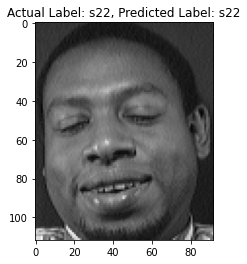

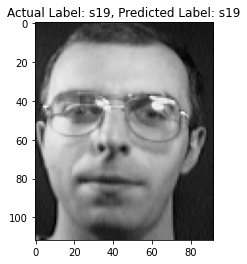

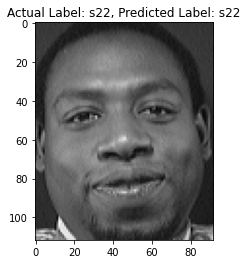

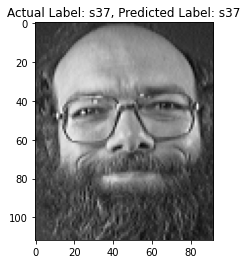

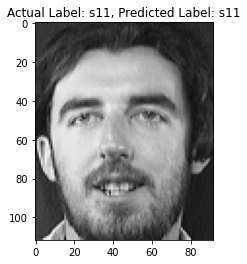

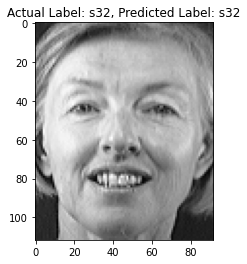

In [17]:
sub_data_ind_list = random.sample(range(0, len(X_test)), 6) 
for ind in sub_data_ind_list:
    fig,ax = plt.subplots(nrows = 1, ncols = 1)
    ax.set_title('Actual Label: ' + Y_test[ind] + ', Predicted Label: ' + PCA_model.predict(X_test[ind]) )
    ax.imshow(X_test[ind].reshape(unprocessed_img_dim), cmap='gray')

## b) Add imposters into the test set and then recognize it as the not enrolled person.

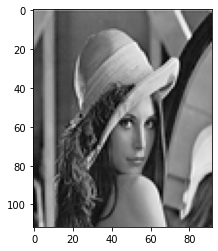

In [20]:
img = cv2.imread('lena_img.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.flatten()
plt.imshow(img.reshape(unprocessed_img_dim), cmap = 'gray')


In [21]:
print(f'Class label for the above image : {PCA_model.predict(img)}')

Class label for the above image : Not Enrolled
